In [1]:
#!pip install featurewiz==0.2.0

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

archivos = []
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        archivos.append(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dset-pequenio/DiccionarioDatos_2023.ods
/kaggle/input/lab1-complete-parquet/downsampled_df.csv
/kaggle/input/lab1-complete-parquet/downsampled_df.parquet
/kaggle/input/dset-peq/dataset_pequeno.csv
/kaggle/input/error-falopa/error_falopa.csv
/kaggle/input/laboratorio-de-imp-i-2023-virtual/kaggle_competencia_muestra.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import category_encoders as ce
import os


from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion    
from sklearn.utils.validation import check_is_fitted

from featurewiz import featurewiz
from scipy import sparse


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

Imported 0.2.00 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



In [5]:
dataset_file = '/kaggle/input/lab1-complete-parquet/downsampled_df.csv'

dataset = pd.read_csv(dataset_file)
dataset.drop(columns='Unnamed: 0', inplace=True)
print(dataset_file)
dataset['clase_ternaria'].replace({'BAJA+2': 1, 'BAJA+1':1, 'CONTINUA':0}, inplace=True)

/kaggle/input/lab1-complete-parquet/downsampled_df.csv


# EDA

In [6]:
def find_cols_with_high_nan(df, threshold=0.80, drop=True): 
    nan_pct = df.isna().sum() / len(df)    
    # Select columns with NaN percentage greater than the threshold
    high_nan_cols = nan_pct[nan_pct > threshold].index.tolist()
    if drop:
        print(f'dropeando {high_nan_cols} porque tienen mas de {threshold} Nan...')
        return df.drop(columns=high_nan_cols)
    return high_nan_cols

def join_visa_master(df):
    print('juntando columnas con prefijo Visa_ y Master_')
    visa_columns = df.filter(like='Visa_').columns.to_list()
    master_columns = df.filter(like='Master_').columns.to_list()
    
    for col_visa, col_master in zip(visa_columns, master_columns):
        new_column_name = 'sum_' + col_visa.split('_', 1)[1]
        
        # Replace NaN values with 0 temporarily for the sum
        visa_values = df[col_visa].fillna(0)
        master_values = df[col_master].fillna(0)
        
        # Sum the non-NaN values and store the result in the new column
        df[new_column_name] = visa_values + master_values
        df[new_column_name] = df[new_column_name].replace(0, np.nan)
    
    return df.drop(columns=visa_columns+master_columns)


def join_cols(df, string):
    joined_cols = df.filter(like=string)
    print(f'sumando las columnas: {joined_cols.columns.to_list()}...')
    
    # Replace NaN values with 0 temporarily for the sum
    joined_cols_filled = joined_cols.fillna(0)
    
    # Calculate the sum
    sum_values = joined_cols_filled.sum(axis=1)
    
    # Replace 0 values with NaN after the summation, but keep the original 0 values when both columns have 0 values in the same row
    df[string] = sum_values.where((joined_cols_filled != 0).any(axis=1), joined_cols_filled.sum(axis=1))
    
    return df.drop(columns=joined_cols.columns)

def find_good_ratios(data):
    '''crea ratios de todas las features float y se queda con los que featurewiz le da importancia, devuelve una lista de buenos candidatos para ratio'''
    def _create_ratios(dataframe, variable,target):
        float_cols = dataframe.select_dtypes(include='float64').columns.tolist()    
        new_dataframe = pd.DataFrame()    
        for col in float_cols:
            if col != variable:
                new_col_name = f'{variable}_to_{col}'
                new_dataframe[new_col_name] = dataframe[variable] / dataframe[col]
                new_dataframe.replace([np.inf, -np.inf], np.nan, inplace=True)

        new_dataframe[target] = dataframe[target]
        return new_dataframe    
    
    the_best = []
    for i in data.select_dtypes(include='float64').columns.tolist():
        temp_df = _create_ratios(data, i,'clase_ternaria')
        try:
            best_ratios = featurewiz(temp_df, 'clase_ternaria',verbose=0)
            the_best.append(best_ratios[0])
        except:
            the_best.append(f'error with {i}')
    return the_best

def create_ratios_from_best(df, lista_best):
    '''crea las features a partir de una lista de listas que tiene los mejores ratios'''
    data = df.copy()    
    for ratios in lista_best:
        if "error" in ratios:
            print(f"Skipping invalid ratio: {ratios}")
            continue
        else:
            for j in ratios:
                variables = j.split('_to_')
                data[j] = data[variables[0]] / data[variables[1]]           
    return data

def preprocessing_dataset(dataset, palabras_agrupar):
    print(dataset.shape)
    dataset = find_cols_with_high_nan(dataset)
    print(dataset.shape)
    dataset = join_visa_master(dataset)
    print(dataset.shape)

    for i in palabras_agrupar:    
        dataset = join_cols(dataset, i)
        print(dataset.shape)
    return dataset

In [7]:
palabras_agrupar =['prestamo','seguro','servicios', 'comisiones','cheques','ahorro','inversion','_consumo','descuentos','tarjeta','consumo','margen','debit','forex', 'transfer','autoservicio','cajas','atm','mobile']

In [ ]:
dataset = preprocessing_dataset(dataset,palabras_agrupar)
list_of_best_ratios = find_good_ratios(dataset)
dataset = create_ratios_from_best(dataset, list_of_best_ratios)

(86870, 155)
dropeando ['Master_Finiciomora', 'Visa_Finiciomora'] porque tienen mas de 0.8 Nan...
(86870, 153)
juntando columnas con prefijo Visa_ y Master_
(86870, 132)
sumando las columnas: ['cprestamos_personales', 'mprestamos_personales', 'cprestamos_prendarios', 'mprestamos_prendarios', 'cprestamos_hipotecarios', 'mprestamos_hipotecarios']...
(86870, 127)
sumando las columnas: ['cseguro_vida', 'cseguro_auto', 'cseguro_vivienda', 'cseguro_accidentes_personales']...
(86870, 124)
sumando las columnas: ['cpagodeservicios', 'mpagodeservicios']...
(86870, 123)
sumando las columnas: ['mcomisiones', 'ccomisiones_mantenimiento', 'mcomisiones_mantenimiento', 'ccomisiones_otras', 'mcomisiones_otras']...
(86870, 119)
sumando las columnas: ['ccheques_depositados', 'mcheques_depositados', 'ccheques_emitidos', 'mcheques_emitidos', 'ccheques_depositados_rechazados', 'mcheques_depositados_rechazados', 'ccheques_emitidos_rechazados', 'mcheques_emitidos_rechazados']...
(86870, 112)
sumando las colum

In [ ]:
cols_keep_as_is = ['active_quarter','cliente_vip','internet','tcuentas','cdescubierto_preacordado','ccaja_seguridad','tcallcenter','thomebanking','cplazo_fijo','cajas','mobile','ccuenta_corriente','cpayroll2_trx','ctrx_quarter','cpayroll_trx']
cols_to_binarize = ['cliente_edad','cliente_antiguedad','cproductos','cpagomiscuentas','ccallcenter_transacciones','chomebanking_transacciones','seguro']
cols_to_normalize = [col for col in dataset.select_dtypes('float').columns if col not in cols_keep_as_is + cols_to_binarize]

#len(cols_keep_as_is + cols_to_binarize+cols_to_normalize) == len(set(cols_keep_as_is + cols_to_binarize+cols_to_normalize))
set(dataset.columns) - set(cols_keep_as_is + cols_to_binarize+cols_to_normalize)

# pipeline preprocessing

In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]


class StandardScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.scaler = StandardScaler()
        
    def fit(self, X, y=None):
        cols_to_scale = self.columns or X.select_dtypes(include='number').columns
        self.scaler.fit(X[cols_to_scale])
        return self
        
    def transform(self, X):
        cols_to_scale = self.columns or X.select_dtypes(include='number').columns
        X_transformed = pd.DataFrame(self.scaler.transform(X[cols_to_scale]), columns=cols_to_scale, index=X.index)
        return pd.concat([X.drop(columns=cols_to_scale), X_transformed], axis=1)
    
    
class PandasFeatureUnion(BaseEstimator, TransformerMixin):
    def __init__(self, transformers):
        self.transformers = transformers

    def fit(self, X, y=None):
        for _, transformer in self.transformers:
            transformer.fit(X, y)
        return self

    def transform(self, X, y=None):
        transformed_dfs = []
        for _, transformer in self.transformers:
            transformed_dfs.append(transformer.transform(X))        
        
        concatenated_df = pd.concat(transformed_dfs, axis=1)
        return concatenated_df
    

class BinTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins, columns=None):
        self.n_bins = n_bins
        self.columns = columns
        
    def fit(self, X, y=None):
        self.quantiles_ = {}
        self.outliers_ = {}
        cols_to_transform = self.columns or X.select_dtypes(include=np.number).columns
        for col in cols_to_transform:          
            q1, q3 = np.percentile(X[col], [25, 75])
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            mask = (X[col] < lower_bound) | (X[col] > upper_bound)
            self.outliers_[col] = mask
            col_no_outliers = X.loc[~mask, col]
            self.quantiles_[col] = pd.qcut(col_no_outliers, self.n_bins, labels=False, duplicates='drop')
        return self

    def transform(self, X):
        check_is_fitted(self)
        X_trans = X.copy()
        cols_to_transform = self.columns or X_trans.select_dtypes(include=np.number).columns
        for col in cols_to_transform:         
            X_trans[col] = pd.cut(X_trans[col], bins=self.n_bins, labels=False, duplicates='drop')
            X_trans.loc[self.outliers_[col].reindex(X.index, fill_value=False).values, col] = 'outlier'
            if col in self.quantiles_:
                X_trans.loc[~self.outliers_[col].reindex(X.index, fill_value=False), col] = 'bin_' + self.quantiles_[col].apply(lambda x: str(x)).astype(str)      
    
        return X_trans[cols_to_transform]
    
    
class OneHotEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_cols=None):
        self.categorical_cols = categorical_cols
    
    def fit(self, X, y=None):
        if self.categorical_cols is None:
            self.categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
        
        self.categories_ = [X[col].astype('category').cat.categories.tolist() + ['dummy'] for col in self.categorical_cols]
        self.encoder = OneHotEncoder(categories=self.categories_, handle_unknown='ignore')
        self.encoder.fit(X[self.categorical_cols])
        return self
    
    def transform(self, X, y=None):
        X_transformed = self.encoder.transform(X[self.categorical_cols])
        feature_names = self.encoder.get_feature_names_out(self.categorical_cols)
        X_transformed_df = pd.DataFrame.sparse.from_spmatrix(X_transformed, columns=feature_names)
        X_transformed_df.index = X.index
        return pd.concat([X.drop(columns=self.categorical_cols), X_transformed_df], axis=1)


class TargetEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None, drop_invariant=False, return_df=True):
        self.cols = cols
        self.drop_invariant = drop_invariant
        self.return_df = return_df
        self.encoder = ce.TargetEncoder(cols=self.cols, drop_invariant=self.drop_invariant, return_df=self.return_df)

    def fit(self, X, y=None):
        self.encoder.fit(X, y)
        return self

    def transform(self, X, y=None):
        return self.encoder.transform(X, y)    
    

class SimpleImputerWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=strategy)
    
    def fit(self, X, y=None):
        self.imputer.fit(X)
        return self
    
    def transform(self, X):
        X_transformed = self.imputer.transform(X)
        return pd.DataFrame(X_transformed, columns=X.columns, index=X.index)
    
    
class PercentageVariationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variable):
        self.variable = variable

    def fit(self, X, y):
        # Combine X and y for easier calculations
        data = pd.concat([X, y], axis=1)

        # Calculate the mean of the variable for different target values
        self.target_means = data.groupby(y.name)[self.variable].mean()
        return self

    def transform(self, X, y=None):
        result = pd.DataFrame()

        # Calculate the percentage variation for each target mean
        for target_value, target_mean in self.target_means.items():
            column_name = f"{self.variable}_pct_variation_{target_value}"
            result[column_name] = (X[self.variable] - target_mean) / target_mean * 100

        return result

## feature engineering

In [ ]:
class RatioFeature(BaseEstimator, TransformerMixin):
    def __init__(self, base_var, other_vars):
        self.base_var = base_var
        self.other_vars = other_vars if other_vars is not None else []

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Asegurarse de que el input es un DataFrame de pandas
        if not isinstance(X, pd.DataFrame):
            raise ValueError("El input debe ser un DataFrame de pandas")

        # Verificar que base_var existe en el DataFrame
        if self.base_var not in X.columns:
            raise ValueError(f"La columna '{self.base_var}' no se encuentra en el DataFrame")

        # Crear un DataFrame vacío para almacenar las nuevas features
        new_features = pd.DataFrame()

        # Calcular las nuevas features
        for var in self.other_vars:
            if var in X.columns:
                feature_name = f"{self.base_var}_{var}_ratio"
                new_features[feature_name] = X[self.base_var] / X[var]
            else:
                raise ValueError(f"La columna '{var}' no se encuentra en el DataFrame")
        return new_features
    
    
class JoinColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, like_strings):
        self.like_strings = like_strings

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Asegurarse de que el input es un DataFrame de pandas
        if not isinstance(X, pd.DataFrame):
            raise ValueError("El input debe ser un DataFrame de pandas")

        # Crear un DataFrame vacío para almacenar las nuevas columnas
        new_cols = pd.DataFrame(index=X.index)

        # Iterar sobre las cadenas especificadas
        for like_string in self.like_strings:
            # Filtrar las columnas que contienen la cadena específica
            joined_cols = X.filter(like=like_string)

            # Crear una nueva columna con la suma de las columnas filtradas
            new_col_name = 'sum_'+like_string
            new_cols[new_col_name] = joined_cols.sum(axis=1)
        return new_cols
    


class StandardScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.scaler = StandardScaler()
        
    def fit(self, X, y=None):
        cols_to_scale = X.select_dtypes(include='number').columns if self.columns is None else self.columns
        self.scaler.fit(X[cols_to_scale])
        return self
        
    def transform(self, X):
        cols_to_scale = X.select_dtypes(include='number').columns if self.columns is None else self.columns
        X_transformed = pd.DataFrame(self.scaler.transform(X[cols_to_scale]), columns=cols_to_scale, index=X.index)
        return pd.concat([X.drop(columns=cols_to_scale), X_transformed], axis=1)    
    


class ReplaceInfTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, factor = 3):
        self.column_max_values = {}
        self.column_min_values = {}
        self.factor = factor

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input should be a pandas DataFrame")

        for column in X.columns:
            max_value = X[column].replace([np.inf, -np.inf], np.nan).max()
            min_value = X[column].replace([np.inf, -np.inf], np.nan).min()

            self.column_max_values[column] = max_value
            self.column_min_values[column] = min_value

        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input should be a pandas DataFrame")

        X_copy = X.copy()

        for column in X_copy.columns:
            if column in self.column_max_values:
                X_copy[column] = X_copy[column].replace(np.inf, self.column_max_values[column] * self.factor)
            if column in self.column_min_values:
                X_copy[column] = X_copy[column].replace(-np.inf, self.column_min_values[column] * self.factor)

        return X_copy

In [ ]:
binning = Pipeline([
    ('col_select',ColumnSelector(columns=cols_to_binarize)),
    ('bin_convert',BinTransformer(columns=None, n_bins = 3)),
    ('onehot', OneHotEncoderTransformer())
    #('target_encoding', TargetEncoderWrapper()) 
])

standarize = Pipeline([
    ('col_select',ColumnSelector(columns=cols_to_normalize)),
    ('scale', StandardScalerTransformer(columns=cols_to_normalize)),
])

feature_engineering = PandasFeatureUnion([
    ('as_is', ColumnSelector(columns=cols_keep_as_is)),
    ('log', standarize),
    ('bin_convert',binning)
])

preprocessing = Pipeline([    
    ('inf', ReplaceInfTransformer()),
    #('fillna', SimpleImputerWrapper(strategy='mean')),
    ('feature_engineering', feature_engineering)
])

In [ ]:
X = dataset.drop('clase_ternaria', axis=1)
y = dataset['clase_ternaria']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# Fit the preprocessing pipeline on the training set and transform both the training and test sets
X_train_processed = preprocessing.fit_transform(X_train, y_train)
X_test_processed = preprocessing.transform(X_test)

# Check the shapes of the processed data
print(X_train_processed.shape, X_test_processed.shape)

## model evaluation

In [ ]:
def get_balanced_classes():
    class_counts = y.value_counts()
    total_samples = class_counts.sum()
    class_frequencies = class_counts / total_samples
    class_weights = 1 / class_frequencies
    return class_weights.to_dict()

class_weights_dict = get_balanced_classes()

In [ ]:
class_weights_dict

In [ ]:
import numpy as np
from sklearn.model_selection._split import _BaseKFold

class WalkForwardCV(_BaseKFold):
    def __init__(self, min_train_size, step):
        n_splits = self._calculate_n_splits(min_train_size, step)
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.min_train_size = min_train_size
        self.step = step

    @staticmethod
    def _calculate_n_splits(min_train_size, step):
        return max((len(X_train_processed) - min_train_size) // step, 0)

    def _iter_test_indices(self, X, y=None, groups=None):
        n_samples = X.shape[0]
        train_start = 0
        while train_start + self.min_train_size < n_samples:
            train_end = train_start + self.min_train_size
            val_end = train_end + self.step
            test_indices = np.arange(train_end, min(val_end, n_samples))
            yield test_indices
            train_start = train_end


import optuna
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from lightgbm import early_stopping, log_evaluation

def objective(trial):
    
    #kf =  KFold(n_splits=3, shuffle=False)
    
    min_train_size = 25000
    step = 6000
    kf = WalkForwardCV(min_train_size=min_train_size, step=step)
    
    f1_scores = []
    for train_index, val_index in kf.split(X_train_processed):
        X_tr, X_val = X_train_processed.iloc[train_index], X_train_processed.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        params = {
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
            "max_depth": trial.suggest_int("max_depth", 1, 10),
            "num_leaves": trial.suggest_int("num_leaves", 2, 128),  # Fix the maximum value for num_leaves
            
            'class_weight': class_weights_dict,  
            #"objective": "multiclass",
            #"metric": "multi_logloss",
            #"num_class": 3,
            "verbosity": -1,
            "boosting_type": "gbdt",   
            'n_jobs': -1,
#             "n_estimators": trial.suggest_int("n_estimators", 100, 1000),          
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 50),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
#             "subsample": trial.suggest_float("subsample", 0.4, 1.0),
#             "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
#             "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
#             "min_gain_to_split": trial.suggest_float("min_gain_to_split", 1e-8, 1.0)
        }

        clf = lgb.LGBMClassifier(device='gpu', **params)
        
        try:
            clf.fit(
                X_tr, y_tr, 
                eval_set=[(X_val, y_val)], 
                callbacks=[early_stopping(50), lgb.log_evaluation(period=50)]
            )    
        
        except lgb.basic.LightGBMError as e:
            print(f"Trial {trial.number} failed with parameters: {params}")
            if len(trial.study.trials) > 1:
                print(f"Current best parameters: {trial.study.best_params}")
            return -float('inf')  # Return very low score to skip this set of hyperparameters

            
        y_pred = clf.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='macro')
        f1_scores.append(f1)

    return sum(f1_scores) / len(f1_scores)

In [ ]:
def optimize_lgbm_hyperparameters():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    print(f"Best trial: {study.best_trial.params}")
    print(f"Best F1 score: {study.best_value}")
    return study.best_trial.params

best_params = optimize_lgbm_hyperparameters()

In [213]:
best_params =  {'learning_rate': 0.0379644295612985, 'max_depth': 8, 'num_leaves': 56, 'min_data_in_leaf': 14, 'feature_fraction': 0.46891355088542147}

In [214]:
import shap
from lightgbm import LGBMClassifier

#class_weight = {0:1, 1:40}

model = LGBMClassifier(device='gpu',class_weight = class_weights_dict, **best_params)

model.fit(X_train_processed, y_train)

y_pred_proba = model.predict_proba(X_test_processed)

[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.46891355088542147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46891355088542147


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import KFold, train_test_split

# Define the KFold cross-validator
# n_splits = 5
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

min_train_size = 25000
step = 6000
kf = WalkForwardCV(min_train_size=min_train_size, step=step)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# Initialize the F1 scores list
f1_scores = []

# Perform cross-validation
for train_index, val_index in kf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Fit the preprocessing pipeline on the training set and transform both the training and validation sets
    X_tr_processed = preprocessing.fit_transform(X_tr, y_tr)
    X_val_processed = preprocessing.transform(X_val)

    # Train the model
    model.fit(X_tr_processed, y_tr)
    
    # Make predictions
    y_pred = model.predict(X_val_processed)
    
    # Calculate the F1 score
    f1 = f1_score(y_val, y_pred, average='macro')
    f1_scores.append(f1)
    
    # Print the F1 score for the current fold
    print(f"F1 score for fold {len(f1_scores)}: {f1:.4f}")

# Calculate and print the average F1 score
average_f1 = np.mean(f1_scores)
print(f"Average F1 score: {average_f1:.4f}")

# Fit the preprocessing pipeline on the entire training set and transform both the training and test sets
X_train_processed = preprocessing.fit_transform(X_train, y_train)
X_test_processed = preprocessing.transform(X_test)

# Train the model on the entire training set
model.fit(X_train_processed, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_processed)

# Plot the confusion matrix for the test set
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

# Print the classification report for the test set
print(classification_report(y_test, y_pred))


F1 score for fold 1: 0.4715
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.46891355088542147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46891355088542147
F1 score for fold 2: 0.3981
Average F1 score: 0.4348


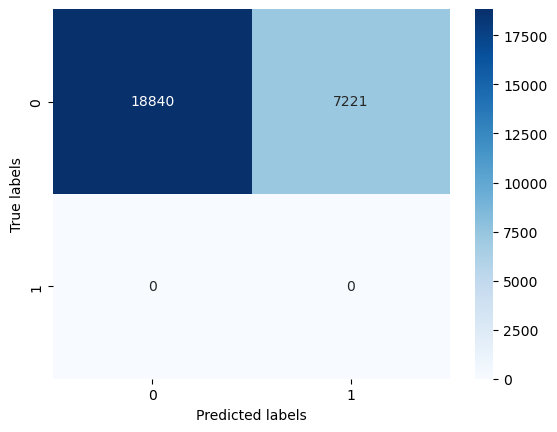

              precision    recall  f1-score   support

           0       1.00      0.72      0.84     26061
           1       0.00      0.00      0.00         0

    accuracy                           0.72     26061
   macro avg       0.50      0.36      0.42     26061
weighted avg       1.00      0.72      0.84     26061



In [215]:
y_pred = model.predict(X_test_processed)

cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()
print(classification_report(y_test, y_pred))

# prediccion

In [123]:
# Read the dataset
predict_set = pd.read_csv('/kaggle/input/dset-peq/dataset_pequeno.csv')

dapply = predict_set[predict_set['foto_mes'] == 202109].drop('clase_ternaria', axis=1)

In [124]:
dapply = preprocessing_dataset(dapply,palabras_agrupar)

(165237, 154)
dropeando ['Master_Finiciomora', 'Visa_Finiciomora'] porque tienen mas de 0.8 Nan...
(165237, 152)
juntando columnas con prefijo Visa_ y Master_
(165237, 131)
sumando las columnas: ['cprestamos_personales', 'mprestamos_personales', 'cprestamos_prendarios', 'mprestamos_prendarios', 'cprestamos_hipotecarios', 'mprestamos_hipotecarios']...
(165237, 126)
sumando las columnas: ['cseguro_vida', 'cseguro_auto', 'cseguro_vivienda', 'cseguro_accidentes_personales']...
(165237, 123)
sumando las columnas: ['cpagodeservicios', 'mpagodeservicios']...
(165237, 122)
sumando las columnas: ['mcomisiones', 'ccomisiones_mantenimiento', 'mcomisiones_mantenimiento', 'ccomisiones_otras', 'mcomisiones_otras']...
(165237, 118)
sumando las columnas: ['ccheques_depositados', 'mcheques_depositados', 'ccheques_emitidos', 'mcheques_emitidos', 'ccheques_depositados_rechazados', 'mcheques_depositados_rechazados', 'ccheques_emitidos_rechazados', 'mcheques_emitidos_rechazados']...
(165237, 111)
sumando l

In [125]:
dapply = create_ratios_from_best(dapply, list_of_best_ratios)

Skipping invalid ratio: error with sum_delinquency
Skipping invalid ratio: error with sum_status
Skipping invalid ratio: error with sum_madelantopesos
Skipping invalid ratio: error with sum_madelantodolares
Skipping invalid ratio: error with sum_mpagosdolares
Skipping invalid ratio: error with sum_cadelantosefectivo


In [180]:
y_pred_result = model.predict_proba(preprocessing.transform(dapply))

# Create a DataFrame for predicted labels using the same index as numero_de_cliente
predicted_df = pd.DataFrame(y_pred_result[:, 1], columns=['proba'], index=dapply.index)

# Combine the numero_de_cliente and predicted labels
end_res = pd.concat([dapply['numero_de_cliente'], predicted_df], axis=1)


In [181]:
def get_nth(end_res, n):
    get_nth = end_res.sort_values('proba', ascending=False).head(n).iloc[-1]['proba']
    end_res['Predicted'] = (end_res['proba'] >= get_nth).astype(int)
    end_res.drop(columns='proba', inplace=True)
    return end_res

In [182]:
end_result = get_nth(end_res,n=8500)

In [183]:
end_result['Predicted'].value_counts()

0    156737
1      8500
Name: Predicted, dtype: int64

In [184]:
end_result.to_csv("K101_001.csv", index=False)

In [185]:
import os
os.environ['KAGGLE_USERNAME'] = 'lechuck666'
os.environ['KAGGLE_KEY'] = '3aaf0a00c8b35504b64d43d4592d6caf'
!kaggle competitions submit -c laboratorio-de-imp-i-2023-virtual -f ./K101_001.csv -m "2nd_less var"

100%|██████████████████████████████████████| 1.81M/1.81M [00:00<00:00, 8.33MB/s]
Successfully submitted to Laboratorio de Imp I, 2023 virtual